# ANC Example Code

In [1]:
!pip install aguaclara

     |████████████████████████████████| 92kB 3.2MB/s 
     |████████████████████████████████| 13.0MB 184kB/s 
     |████████████████████████████████| 163kB 39.4MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.1.13-cp36-none-any.whl size=97010 sha256=ee2416a46160fc3598281daa7fcb940148c53c04ec0b45b8ffc3fd3ebba96d25
  Stored in directory: /root/.cache/pip/wheels/13/65/3f/fa24d7d43535d7c44774b8f05d782324a26a155afc5447de05
  Created wheel for pint: filename=Pint-0.8.1-py2.py3-none-any.whl size=134155 sha256=3b80f7f26acf68b566a5678d7aabe49736c8fa8c4c22c2d47f011f3036a355d4
  Stored in directory: /root/.cache/pip/wheels/b4/56/36/7c4d6a4e3660e233b95e3b0482551915cb184abca0f93ee1dd
Successfully built aguaclara pint
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.2
    Uninstalling matplotlib-3.1.2:
      Successfully uninstalled matplotlib-3.1.2


In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy import special
from scipy.optimize import curve_fit
import collections

In [0]:
Gran_data = 'https://raw.githubusercontent.com/monroews/CEE4530/master/Examples/data/Gran.xls'
# The ac.Gran function imports data from your Gran data file as saved by ProCoDA.
# The ac.Gran function assigns all of the outputs in one statement

# The following function is in epa and should be fixed and released in the next release.

def Gran(data_file_path):
    """Extract the data from a ProCoDA Gran plot file. The file must be the original tab delimited file.
    :param data_file_path: The path to the file. If the file is in the working directory, then the file name is sufficient.
    :return: collection of
        * **V_titrant** (*float*) - Volume of titrant in mL
        * **ph_data** (*numpy.array*) - pH of the sample
        * **V_sample** (*float*) - Volume of the original sample that was titrated in mL
        * **Normality_titrant** (*float*) - Normality of the acid used to titrate the sample in mole/L
        * **V_equivalent** (*float*) - Volume of acid required to consume all of the ANC in mL
        * **ANC** (*float*) - Acid Neutralizing Capacity of the sample in mole/L
    """
    df = pd.read_csv(data_file_path, delimiter='\t', header=5)
    V_t = np.array(pd.to_numeric(df.iloc[0:, 0]))*u.mL
    pH = np.array(pd.to_numeric(df.iloc[0:, 1]))
    df = pd.read_csv(data_file_path, delimiter='\t', header=None, nrows=5)
    V_S = pd.to_numeric(df.iloc[0, 1])*u.mL
    N_t = pd.to_numeric(df.iloc[1, 1])*u.mole/u.L
    V_eq = pd.to_numeric(df.iloc[2, 1])*u.mL
    ANC_sample = pd.to_numeric(df.iloc[3, 1])*u.mole/u.L
    Gran_collection = collections.namedtuple('Gran_results', 'V_titrant ph_data V_sample Normality_titrant V_equivalent ANC')
    Gran = Gran_collection(V_titrant=V_t, ph_data=pH, V_sample=V_S,
                           Normality_titrant=N_t, V_equivalent=V_eq,
                           ANC=ANC_sample)
    return Gran

V_titrant, pH, V_sample, Normality_Titrant, V_equivalent, ANC = Gran(Gran_data)

## Equation for the First Gran Function
$${F_1}  =  \frac{{{V_S} + {V_T}}}{{{V_S}}}{\text{[}}{{\text{H}}^ + }{\text{]}}$$

The ANC can be calculated from the equivalent volume from
$$ANC=\frac{V_e N_t }{V_s }$$

The r value for this curve fit is 0.99999
The equivalent volume was 0.21 milliliter
The acid neutralizing capacity was 0.43 milliequivalent / liter


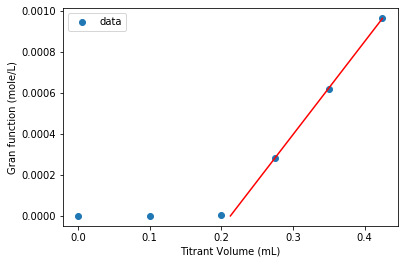

In [17]:
#Define the gran function.
def F1(V_sample,V_titrant,pH):
  return (V_sample + V_titrant)/V_sample * ac.invpH(pH)
#Create an array of the F1 values.
F1_data = F1(V_sample,V_titrant,pH)
#By inspection I guess that there are 4 good data points in the linear region.
N_good_points = 3
#use scipy linear regression. Note that the we can extract the last n points from an array using the notation [-N:]
slope, intercept, r_value, p_value, std_err = stats.linregress(V_titrant[-N_good_points:],F1_data[-N_good_points:])
#reattach the correct units to the slope and intercept.
intercept = intercept*u.mole/u.L
slope = slope*(u.mole/u.L)/u.mL
V_eq = -intercept/slope
ANC_sample = V_eq*Normality_Titrant/V_Sample
print('The r value for this curve fit is', ac.round_sig_figs(r_value,5))
print('The equivalent volume was', ac.round_sig_figs(V_eq,2))
print('The acid neutralizing capacity was',ac.round_sig_figs(ANC_sample.to(u.meq/u.L),2))

#The equivalent volume agrees well with the value calculated by ProCoDA.
#create an array of points to draw the linear regression line
x=[V_eq.magnitude,V_titrant[-1].magnitude ]
y=[0,(V_titrant[-1]*slope+intercept).magnitude]
#Now plot the data and the linear regression
plt.plot(V_titrant, F1_data,'o')
plt.plot(x, y,'r')
plt.xlabel('Titrant Volume (mL)')
plt.ylabel('Gran function (mole/L)')
plt.legend(['data'])
plt.show()